Overview

The paper introduces NGBoost, a method for boosting that focuses on probabilistic predictions rather than just point estimates. It combines the strengths of gradient boosting with the concept of natural gradients to improve the learning process for models that predict probabilities.

Key Concepts

1. Boosting:

- Boosting is a machine learning technique that combines multiple weak learners (simple models) to create a strong learner (a more accurate model).

- Traditional boosting methods often focus on predicting a single value (like a class label) rather than the full probability distribution of outcomes.

2. Probabilistic Predictions:

- NGBoost aims to predict the probability of different outcomes given some input data (X). For example, instead of just predicting whether it will rain or not, it predicts the probability of rain.

3. Scoring Rules:

- The method starts by selecting a scoring rule to evaluate how well the predicted probabilities match the actual outcomes. This helps in measuring the quality of the predictions.

4. Natural Gradient:

- The paper introduces the concept of the natural gradient, which adjusts the standard gradient descent method to account for the geometry of the space of probability distributions.

- This adjustment helps the model learn more effectively by ensuring that updates to the model parameters are more aligned with the true nature of the data.

5. Training Process:

- The training process involves fitting the model parameters using gradient boosting while applying the natural gradient to improve the learning dynamics.

- This results in better convergence and more accurate probability estimates.

Benefits of NGBoost

- Improved Predictions: By focusing on probabilities, NGBoost can provide more informative predictions, which is especially useful in applications like risk assessment and decision-making.

- Flexibility: NGBoost can be applied to various types of data and problems, making it a versatile tool in machine learning.

- Efficiency: The use of natural gradients leads to faster and more reliable training compared to traditional methods.

Conclusion

NGBoost represents a significant advancement in the field of machine learning by combining the principles of boosting with probabilistic modeling and natural gradient optimization. This approach allows for more accurate and meaningful predictions, making it a valuable tool for practitioners.

In summary, NGBoost is about enhancing the way we make predictions in machine learning by focusing on probabilities and using smarter optimization techniques to improve the learning process.

In [2]:
from analysis.datasets import *
from analysis.daily import *

import pandas as pd
import matplotlib.pyplot as plt

from ngboost import NGBRegressor
from sklearn.metrics import mean_squared_error

In [7]:
load_wind_park_data().index.max()

Data loaded and transformed successfully. Shape of DataFrame: (78192, 22)


Timestamp('2024-12-01 23:00:00')

In [ ]:
# Example usage
wind_park_data = load_wind_park_data()
display(wind_park_data.head(3))
electricity_data = load_entsoe()
display(electricity_data.head(3))

merged_df = process_and_merge_dataframes(wind_park_data, electricity_data)
merged_df = merged_df.dropna()
display(merged_df.head(3))

time = "09:30"
df_time = get_columns_by_time(merged_df, time)
display(df_time.head(3))
df_time.columns = [c[:-6] for c in df_time.columns]
display(df_time.head(3))

train, validation, test = to_train_validation_test_data(df_time, "2023-01-01", "2024-01-01")

def transform(df):
    df = df.copy()
    df["onshore_m1"] = df["onshore"].shift(1)
    df = df.dropna()
    y = df["onshore"]
    X = df.drop(columns=["onshore"])
    return X, y

X_train, y_train = transform(train)
X_val, y_val = transform(validation)


from ngboost.scores import LogScore, CRPScore
from ngboost.distns import Normal

model = NGBRegressor(Dist=Normal, Score=CRPScore)

model.fit(X_train, y_train)

y_preds = model.predict(X_train)
y_dists = model.pred_dist(X_train)

# train Mean Squared Error
mse = mean_squared_error(y_preds, y_train)
print('train MSE', mse)

# train Negative Log Likelihood
nll = -y_dists.logpdf(y_train).mean()
print('train NLL', nll)

pd.DataFrame({"y": y_train, "mu": y_preds, "sigma": [y.scale for y in y_dists]})


start = 0
end = 30
x = y_train.index[start:end]
y = y_train[start:end]
mu = y_preds[start:end]
sigma = [y.scale for y in y_dists][start:end]
# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, label="True Values (y)", color="green", alpha=0.5)
plt.plot(x, mu, label="Predicted Values (mu)", color="red", alpha=0.5)
plt.fill_between(x, mu - sigma, mu + sigma, color="orange", alpha=0.3, label="Uncertainty Band (mu ± sigma)")

# Customize the plot
plt.xlabel("Index")
plt.ylabel("Value")
plt.title(f"True Values, Predictions, and Uncertainty Band at {time}")
plt.legend()
plt.grid(alpha=0.3)


y_preds = model.predict(X_val)
y_dists = model.pred_dist(X_val)

# val Mean Squared Error
val_mse = mean_squared_error(y_preds, y_val)
print('Val MSE', val_mse)

# val Negative Log Likelihood
val_nll = -y_dists.logpdf(y_val).mean()
print('Val NLL', val_nll)


start = 0
end = 30
x = y_val.index[start:end]
y = y_val[start:end]
mu = y_preds[start:end]
sigma = [y.scale for y in y_dists][start:end]
# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, label="True Values (y)", color="green", alpha=0.5)
plt.plot(x, mu, label="Predicted Values (mu)", color="red", alpha=0.5)
plt.fill_between(x, mu - sigma, mu + sigma, color="orange", alpha=0.3, label="Uncertainty Band (mu ± sigma)")

# Customize the plot
plt.xlabel("Index")
plt.ylabel("Value")
plt.title(f"True Values, Predictions, and Uncertainty Band at {time}")
plt.legend()
plt.grid(alpha=0.3)


In [2]:
# Example usage
wind_park_data = load_wind_park_data()
display(wind_park_data.head(3))
electricity_data = load_entsoe()
display(electricity_data.head(3))

merged_df = process_and_merge_dataframes(wind_park_data, electricity_data)
merged_df = merged_df.dropna()
display(merged_df.head(3))


Data loaded and transformed successfully. Shape of DataFrame: (78192, 22)


,wind_speed_10m_51.84534_13.656307,wind_speed_10m_51.98594_13.045872,wind_speed_10m_52.26713_11.312384,wind_speed_10m_mean,wind_speed_10m_52.618626_12.761193,wind_speed_10m_52.829525_11.6510315,wind_speed_10m_52.97012_12.372882,wind_speed_10m_53.110718_12.079395,wind_speed_10m_53.18102_11.761364,wind_speed_10m_53.321613_13.859315,...,wind_speed_100m_51.98594_13.045872,wind_speed_100m_52.26713_11.312384,wind_speed_100m_mean,wind_speed_100m_52.618626_12.761193,wind_speed_100m_52.829525_11.6510315,wind_speed_100m_52.97012_12.372882,wind_speed_100m_53.110718_12.079395,wind_speed_100m_53.18102_11.761364,wind_speed_100m_53.321613_13.859315,wind_speed_100m_53.46221_13.7404585
time,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,2.48,2.41,2.48,1.94,1.86,1.84,1.80,1.97,1.80,1.90,...,5.16,5.71,4.52,4.33,5.02,4.47,4.86,5.00,3.72,4.27
2016-01-01 01:00:00,2.77,2.55,2.62,2.00,2.00,2.05,1.78,1.94,1.72,2.02,...,5.50,5.97,4.69,4.47,5.24,4.48,4.72,4.83,3.86,4.38
2016-01-01 02:00:00,2.75,2.62,2.64,2.12,2.12,2.06,1.91,2.06,1.84,1.90,...,5.49,5.87,4.97,4.80,5.32,4.65,4.84,4.94,3.98,4.33


,offshore,onshore
time,,
2016-01-01 00:00:00,21.0,1428.0
2016-01-01 00:15:00,27.0,1379.0
2016-01-01 00:30:00,24.0,1399.0


,wind_speed_10m_mean_00_00,wind_speed_10m_mean_00_15,wind_speed_10m_mean_00_30,wind_speed_10m_mean_00_45,wind_speed_10m_mean_01_00,wind_speed_10m_mean_01_15,wind_speed_10m_mean_01_30,wind_speed_10m_mean_01_45,wind_speed_10m_mean_02_00,wind_speed_10m_mean_02_15,...,onshore_21_30,onshore_21_45,onshore_22_00,onshore_22_15,onshore_22_30,onshore_22_45,onshore_23_00,onshore_23_15,onshore_23_30,onshore_23_45
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,1.94,1.9550,1.970,1.9850,2.00,2.030,2.06,2.090,2.12,2.1225,...,316.0,350.0,359.0,385.0,425.0,432.0,467.0,503.0,509.0,528.0
2016-01-02,2.83,2.8250,2.820,2.8150,2.81,2.835,2.86,2.885,2.91,2.9975,...,6813.0,6809.0,6785.0,6760.0,6790.0,6771.0,6700.0,6682.0,6672.0,6721.0
2016-01-03,5.83,5.8325,5.835,5.8375,5.84,5.840,5.84,5.840,5.84,5.8425,...,5377.0,5335.0,5253.0,5296.0,5265.0,5255.0,5255.0,5239.0,5234.0,5220.0


In [3]:
time = "09:30"
df_time = get_columns_by_time(merged_df, time)
display(df_time.head(3))
df_time.columns = [c[:-6] for c in df_time.columns]
display(df_time.head(3))

,wind_speed_10m_mean_09_30,wind_speed_100m_mean_09_30,onshore_09_30
date,,,
2016-01-01,2.110,4.205,951.0
2016-01-02,5.175,7.930,4758.0
2016-01-03,5.515,8.310,5702.0


,wind_speed_10m_mean,wind_speed_100m_mean,onshore
date,,,
2016-01-01,2.110,4.205,951.0
2016-01-02,5.175,7.930,4758.0
2016-01-03,5.515,8.310,5702.0


In [4]:
df_time.index.min(), df_time.index.max(), df_time.count()

(Timestamp('2016-01-01 00:00:00'),
 Timestamp('2024-10-10 00:00:00'),
 wind_speed_10m_mean     3206
 wind_speed_100m_mean    3206
 onshore                 3206
 dtype: int64)

In [5]:
train, validation, test = to_train_validation_test_data(df_time, "2023-01-01", "2024-01-01")

# of training observations: 2557 | 79.76%
# of validation observations: 365 | 11.38%
# of test observations: 284 | 8.86%


In [6]:
print("train:", train.index.min(), train.index.max())
print("val:", validation.index.min(), validation.index.max())
print("test:", test.index.min(), test.index.max())

train: 2016-01-01 00:00:00 2022-12-31 00:00:00
val: 2023-01-01 00:00:00 2023-12-31 00:00:00
test: 2024-01-01 00:00:00 2024-10-10 00:00:00


In [7]:
def transform(df):
    df = df.copy()
    df["onshore_m1"] = df["onshore"].shift(1)
    df = df.dropna()
    y = df["onshore"]
    X = df.drop(columns=["onshore"])
    return X, y


In [8]:
X_train, y_train = transform(train)
X_val, y_val = transform(validation)

In [9]:
from ngboost.scores import LogScore, CRPScore
from ngboost.distns import Normal

In [10]:
model = NGBRegressor(Dist=Normal, Score=CRPScore)

In [11]:
model.fit(X_train, y_train)

[iter 0] loss=1870.1748 val_loss=0.0000 scale=512.0000 norm=452.6658
[iter 100] loss=1592.7554 val_loss=0.0000 scale=512.0000 norm=408.7787
[iter 200] loss=1377.0597 val_loss=0.0000 scale=512.0000 norm=371.7943
[iter 300] loss=1204.5239 val_loss=0.0000 scale=512.0000 norm=342.1967
[iter 400] loss=1062.7566 val_loss=0.0000 scale=512.0000 norm=320.2085


NGBRegressor(Score=<class 'ngboost.scores.CRPScore'>,
             random_state=RandomState(MT19937) at 0x1DBA1B07C40)

In [12]:
y_preds = model.predict(X_train)
y_dists = model.pred_dist(X_train)

# train Mean Squared Error
mse = mean_squared_error(y_preds, y_train)
print('train MSE', mse)

# train Negative Log Likelihood
nll = -y_dists.logpdf(y_train).mean()
print('train NLL', nll)

train MSE 3437941.611170776
train NLL 8.867858751943569


In [13]:
X_train

,wind_speed_10m_mean,wind_speed_100m_mean,onshore_m1
date,,,
2016-01-02,5.175,7.930,951.0
2016-01-03,5.515,8.310,4758.0
2016-01-04,4.930,7.640,5702.0
2016-01-05,4.450,6.600,3013.0
2016-01-06,3.515,5.110,1721.0
...,...,...,...
2022-12-27,6.345,10.280,7328.0
2022-12-28,6.250,10.715,11375.0
2022-12-29,6.585,11.150,10855.0


In [14]:
y_train

date
2016-01-02     4758.0
2016-01-03     5702.0
2016-01-04     3013.0
2016-01-05     1721.0
2016-01-06      938.0
               ...   
2022-12-27    11375.0
2022-12-28    10855.0
2022-12-29    10845.0
2022-12-30     5340.0
2022-12-31     9537.0
Name: onshore, Length: 2556, dtype: float64

In [15]:
pd.DataFrame({"y": y_train, "mu": y_preds, "sigma": [y.scale for y in y_dists]})

,y,mu,sigma
date,,,
2016-01-02,4758.0,5105.597505,2905.974637
2016-01-03,5702.0,5315.674441,2827.082496
2016-01-04,3013.0,4875.120328,2716.734554
2016-01-05,1721.0,3556.078437,2016.026979
2016-01-06,938.0,2272.014272,1984.849518
...,...,...,...
2022-12-27,11375.0,6670.793475,4719.812541
2022-12-28,10855.0,6888.354059,4884.320687
2022-12-29,10845.0,6888.354059,5363.197565


results for train

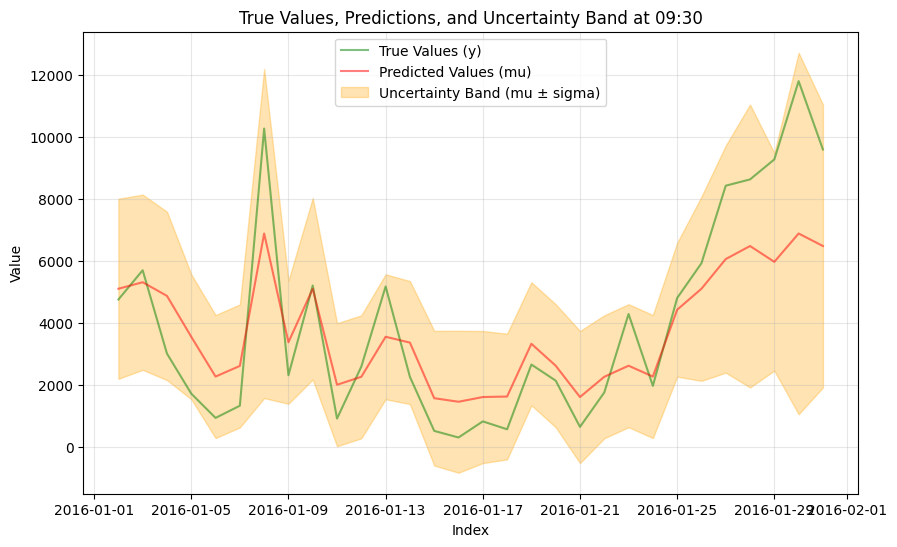

In [16]:
start = 0
end = 30
x = y_train.index[start:end]
y = y_train[start:end]
mu = y_preds[start:end]
sigma = [y.scale for y in y_dists][start:end]
# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, label="True Values (y)", color="green", alpha=0.5)
plt.plot(x, mu, label="Predicted Values (mu)", color="red", alpha=0.5)
plt.fill_between(x, mu - sigma, mu + sigma, color="orange", alpha=0.3, label="Uncertainty Band (mu ± sigma)")

# Customize the plot
plt.xlabel("Index")
plt.ylabel("Value")
plt.title(f"True Values, Predictions, and Uncertainty Band at {time}")
plt.legend()
plt.grid(alpha=0.3)

Results for val

In [17]:
y_preds = model.predict(X_val)
y_dists = model.pred_dist(X_val)

# val Mean Squared Error
val_mse = mean_squared_error(y_preds, y_val)
print('Val MSE', val_mse)

# val Negative Log Likelihood
val_nll = -y_dists.logpdf(y_val).mean()
print('Val NLL', val_nll)

Val MSE 5880431.0927422475
Val NLL 8.986781121261618


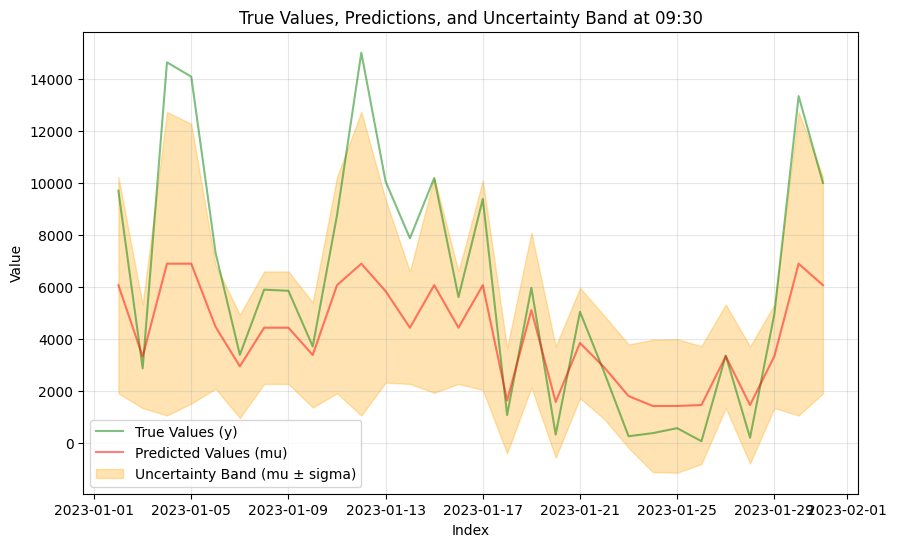

In [18]:
start = 0
end = 30
x = y_val.index[start:end]
y = y_val[start:end]
mu = y_preds[start:end]
sigma = [y.scale for y in y_dists][start:end]
# Plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, label="True Values (y)", color="green", alpha=0.5)
plt.plot(x, mu, label="Predicted Values (mu)", color="red", alpha=0.5)
plt.fill_between(x, mu - sigma, mu + sigma, color="orange", alpha=0.3, label="Uncertainty Band (mu ± sigma)")

# Customize the plot
plt.xlabel("Index")
plt.ylabel("Value")
plt.title(f"True Values, Predictions, and Uncertainty Band at {time}")
plt.legend()
plt.grid(alpha=0.3)